In [2]:
%config InlineBackend.figure_formats = ['png']
%matplotlib inline
import os
import sys
import math
import shutil
import tempfile
import numpy as np
import matplotlib.pyplot as plt
from pycalphad import Database, binplot, calculate, equilibrium
from pycalphad.plot.utils import phase_legend
import pycalphad.variables as v
import pandas as pd
plt.rcParams.update({'font.size': 18}) # defaults to 10.0

# Analyze the TDB file

load the database file

In [3]:
db = Database('CrFe_Jacob.tdb')

Get a list of phases and plot the phase diagram of the FeCr system.

In [4]:
phases = list(db.phases.keys())
phases

['BCC_A2', 'FCC_A1', 'LIQUID', 'SIGMA']

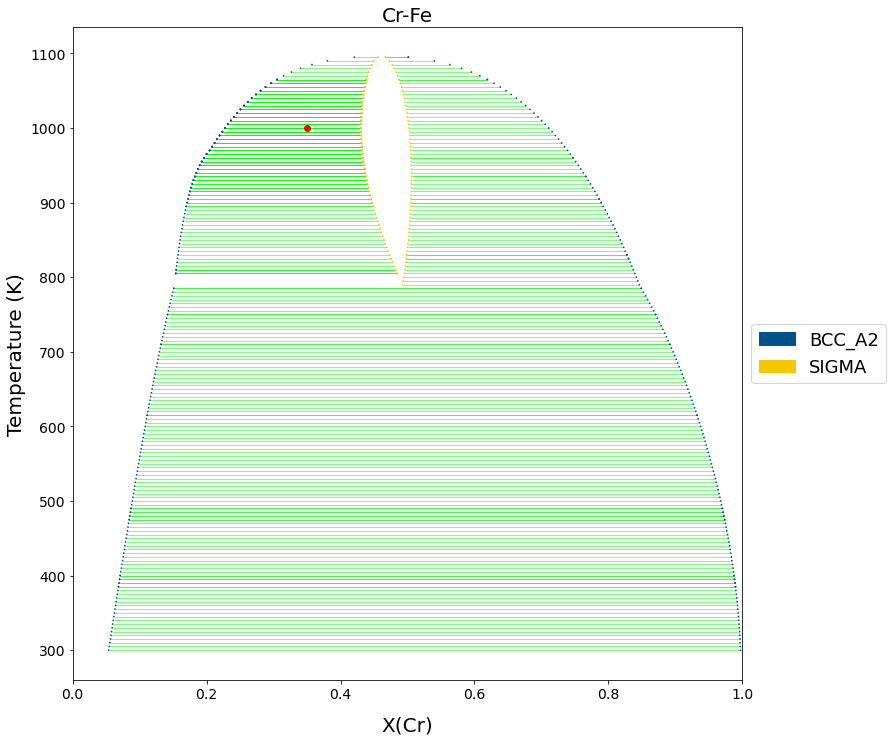

In [5]:
fig = plt.figure(figsize=(15,12))
ax=fig.gca()
binplot(db, ['Cr', 'Fe', 'VA'] , phases, 
        {v.X('Cr'):(0,1,0.005), v.T: (300, 1100, 5), v.P:101325}, plot_kwargs={'ax': ax})

# Plot the point where we initiate the example simulation
ax.plot(0.35, 1000, "or")

we can compute the free energies at 1000K using pycalphad

In [6]:
eq_bcc = equilibrium(db, ['Cr', 'Fe', 'VA'], ['BCC_A2'], {v.X('CR'): (0,1, 0.01), v.T: 1000, v.P:101325 })
eq_sigma = equilibrium(db, ['Cr', 'Fe', 'VA'], ['SIGMA'], {v.X('CR'): (0,1, 0.01), v.T: 1000, v.P:101325 })

Those will be plotted below as a reference solution to compare to the MOOSE output.

# Solving for sublattice concentrations

Run 

```
../../phase_field-opt -i CrFe_sigma.i
```

To perform a solve for only the sigma phase sublattice concentrations.

load the solution

In [8]:
F = pd.read_csv('CrFe_sigma_out_var_0001.csv')

And plot free energies (both from pycalphad and from MOOSE)

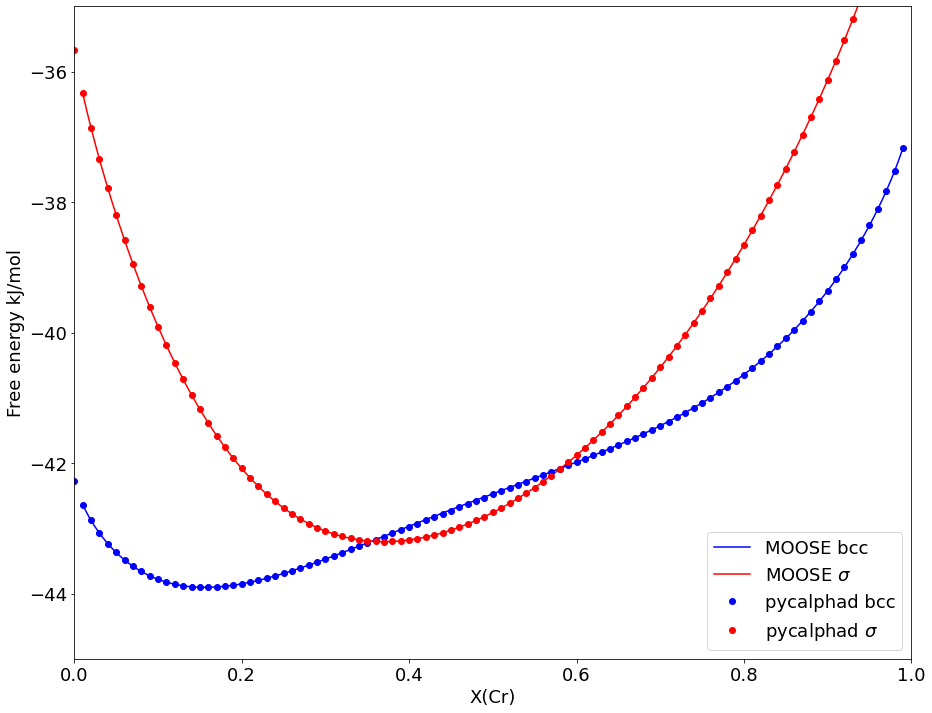

In [12]:
fig = plt.figure(figsize=(15,12))
ax = fig.gca()

# Plot the MOOSE free energies ...
ax.plot(F['cCr'], F['Fb']/1000, 'b-', label="MOOSE bcc")
ax.plot(F['cCr'], F['Fs']/1000, 'r-', label="MOOSE $\sigma$")

# ... and the pycalphad free energies
ax.plot(eq_bcc['X_CR'].values,  eq_bcc['GM'].values[0][0][0]/1000, 'bo', label="pycalphad bcc")
ax.plot(eq_sigma['X_CR'].values, eq_sigma['GM'].values[0][0][0]/1000, 'ro', label="pycalphad $\sigma$")

ax.set_xlabel('X(Cr)')
ax.set_ylabel('Free energy kJ/mol')
ax.legend(loc='lower right')
ax.set_xlim((0, 1))
ax.set_ylim((-45,-35))
plt.show()

The free energies evaluated and solved for by MOOSE, exactly match the pycalphad free energies.

Now let's plot the sublattice concentrations as a function of the total chromium concentration.

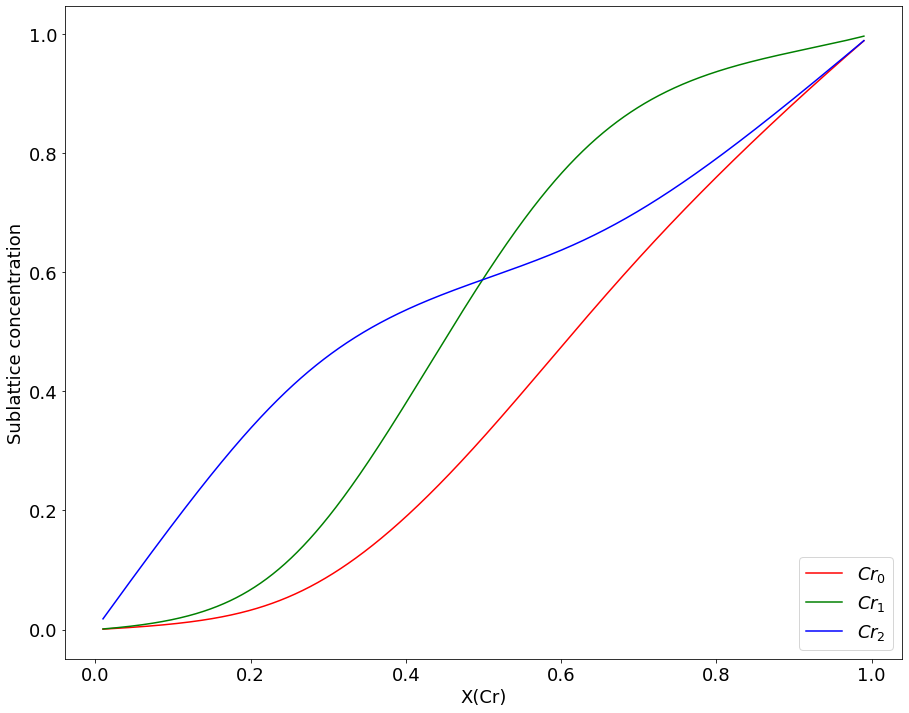

In [10]:
fig = plt.figure(figsize=(15,12))
ax = fig.gca()
ax.plot(F['cCr'], F['SIGMA_0CR'], 'r-', label="$Cr_0$")
ax.plot(F['cCr'], F['SIGMA_1CR'], 'g-', label="$Cr_1$")
ax.plot(F['cCr'], F['SIGMA_2CR'], 'b-', label="$Cr_2$")
ax.set_xlabel('X(Cr)')
ax.set_ylabel('Sublattice concentration')
ax.legend(loc='lower right')
plt.show()

In [27]:
F

,Fb,Fs,SIGMA_0CR,SIGMA_1CR,SIGMA_2CR,cCr,dFs,dFs0,dFs1,dFs2,id,x,y,z
0,-465.689885,-36329.879387,0.000730,0.001041,0.018033,0.010000,-56488.387517,-18830.134904,-30128.215616,0,0.000000,0.010000,0,0
1,-502.771789,-36385.288990,0.000803,0.001148,0.019800,0.010981,-55653.555210,-18551.747286,-29682.795735,0,0.000981,0.010981,0,0
2,-539.116936,-36439.879507,0.000877,0.001257,0.021567,0.011962,-54879.685104,-18293.705584,-29269.928930,0,0.001962,0.011962,0,0
3,-574.785082,-36493.710709,0.000950,0.001366,0.023333,0.012943,-54157.525226,-18052.918501,-28884.669616,0,0.002943,0.012943,0,0
4,-609.826921,-36546.833306,0.001024,0.001476,0.025098,0.013924,-53479.782598,-17826.950410,-28523.120663,0,0.003924,0.013924,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-609.826921,-33063.321692,0.984387,0.995338,0.984816,0.986076,46543.967847,15515.011647,24824.018635,0,0.976076,0.986076,0,0
996,-574.785082,-33017.083171,0.985493,0.995656,0.985885,0.987057,47139.652120,15713.626963,25141.803140,0,0.977057,0.987057,0,0
997,-539.116936,-32970.216676,0.986598,0.995976,0.986953,0.988038,47779.698329,15927.042816,25483.268505,0,0.978038,0.988038,0,0
998,-502.771789,-32922.671552,0.987702,0.996297,0.988023,0.989019,48471.399956,16157.695081,25852.312128,0,0.979019,0.989019,0,0
